In [1]:
import librosa

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
import torchmetrics
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cpu')

In [4]:
# config
class Config:
    SR = 44110
    N_MFCC = 13
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 128
    N_EPOCHS = 5
    LR = 0.001
    SEED = 42
    
CONFIG = Config()

In [5]:
def seed_everything(seed):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED)

In [6]:
df = pd.read_csv('./open/train.csv')
train, val, _, _ = train_test_split(df, df['label'], test_size=0.15, random_state=CONFIG.SEED)

In [7]:
train

,id,path,label
26281,VVNZTZTD,./train/VVNZTZTD.ogg,real
34885,ODEMMPPF,./train/ODEMMPPF.ogg,real
4455,QEOXEJVH,./train/QEOXEJVH.ogg,fake
5795,FIFTBXDS,./train/FIFTBXDS.ogg,fake
5264,LMBMMIPZ,./train/LMBMMIPZ.ogg,fake
...,...,...,...
44732,PWTCAYUB,./train/PWTCAYUB.ogg,fake
54343,HSAHCTUQ,./train/HSAHCTUQ.ogg,real
38158,CXJSUSJK,./train/CXJSUSJK.ogg,fake
860,ZBTGTORE,./train/ZBTGTORE.ogg,real


In [8]:
val

,id,path,label
49798,PUOXNOKJ,./train/PUOXNOKJ.ogg,real
54292,GXOIPDJP,./train/GXOIPDJP.ogg,fake
40359,FOEQKPPR,./train/FOEQKPPR.ogg,fake
50441,IYASAVDT,./train/IYASAVDT.ogg,real
37723,VLWIXPTC,./train/VLWIXPTC.ogg,real
...,...,...,...
25347,AJBSHFMM,./train/AJBSHFMM.ogg,real
44957,MIBKRXMU,./train/MIBKRXMU.ogg,fake
14632,SOJSEKTY,./train/SOJSEKTY.ogg,real
23578,SUNQCCNT,./train/SUNQCCNT.ogg,fake


In [9]:
os.path.join("./open",val["path"][49798])

'./open/./train/PUOXNOKJ.ogg'

In [10]:
data = "./open/train/PUOXNOKJ.ogg"

In [11]:
from IPython.display import Audio

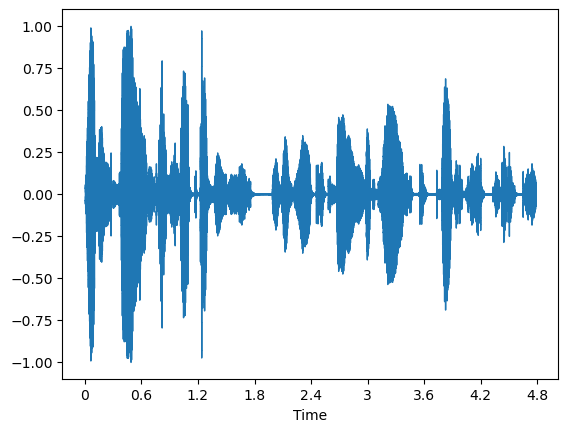

In [12]:
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

In [13]:
def get_mfcc_feature(df, train_mode=True):
    features = []
    labels = []
    path = "./open"
    
    for _, row in tqdm(df.iterrows()):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(os.path.join(path, row['path']), sr=CONFIG.SR)
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CONFIG.N_MFCC)
        mfcc = np.mean(mfcc.T, axis=0)
        features.append(mfcc)

        if train_mode:
            label = row['label']
            label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
            label_vector[0 if label == 'fake' else 1] = 1
            labels.append(label_vector)

    if train_mode:
        return features, labels
    return features

In [14]:
import numpy as np

train_mfcc = np.load('./open/feature/train_mfcc.npy')
train_labels = np.load('./open/feature/train_labels.npy')
val_mfcc = np.load('./open/feature/val_mfcc.npy')
val_labels = np.load('./open/feature/val_labels.npy')

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [16]:
train_labels[0]

array([0., 1.])

In [17]:
np.array(train_labels).shape

(47122, 2)

In [18]:
train_mfcc_numpy = np.array(train_mfcc)
train_labels_numpy = np.array(train_labels)

train_labels_new = np.array(train_labels)

# 데이터 확인
print("Features shape:", train_mfcc_numpy.shape)
print("Labels shape:", train_labels_new.shape)

Features shape: (47122, 13)
Labels shape: (47122, 2)


In [19]:
val_mfcc_numpy = np.array(val_mfcc)
val_labels_numpy = np.array(val_labels)

In [20]:
# 모델 정의
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# 모델 생성
model = create_model(train_mfcc_numpy.shape[1], CONFIG.N_CLASSES)

# 모델 컴파일
model.compile(optimizer=Adam(CONFIG.LR), loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=10)

In [22]:
history = model.fit(train_mfcc_numpy, train_labels_new, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[es], verbose=2)

Epoch 1/100
1179/1179 - 1s - 815us/step - accuracy: 0.6035 - loss: 1.4716 - val_accuracy: 0.7540 - val_loss: 0.5472
Epoch 2/100
1179/1179 - 1s - 538us/step - accuracy: 0.7513 - loss: 0.5150 - val_accuracy: 0.8384 - val_loss: 0.3660
Epoch 3/100
1179/1179 - 1s - 516us/step - accuracy: 0.8179 - loss: 0.4116 - val_accuracy: 0.8539 - val_loss: 0.3139
Epoch 4/100
1179/1179 - 1s - 521us/step - accuracy: 0.8392 - loss: 0.3669 - val_accuracy: 0.8502 - val_loss: 0.3249
Epoch 5/100
1179/1179 - 1s - 512us/step - accuracy: 0.8514 - loss: 0.3488 - val_accuracy: 0.8752 - val_loss: 0.2883
Epoch 6/100
1179/1179 - 1s - 511us/step - accuracy: 0.8588 - loss: 0.3296 - val_accuracy: 0.8892 - val_loss: 0.2650
Epoch 7/100
1179/1179 - 1s - 524us/step - accuracy: 0.8647 - loss: 0.3101 - val_accuracy: 0.8934 - val_loss: 0.2583
Epoch 8/100
1179/1179 - 1s - 521us/step - accuracy: 0.8743 - loss: 0.2959 - val_accuracy: 0.8939 - val_loss: 0.2420
Epoch 9/100
1179/1179 - 1s - 518us/step - accuracy: 0.8750 - loss: 0.288

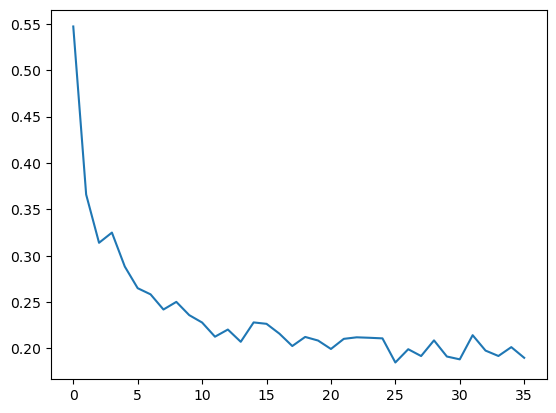

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])

In [24]:
from sklearn.metrics import roc_auc_score

def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score

In [25]:
def validation(model, val_features, val_labels, loss_fn):
    val_loss, all_labels, all_probs = [], [], []
    
    for i in tqdm(range(len(val_features))):
        features = val_features[i:i+1]
        labels = val_labels[i:i+1]
        
        # 모델 예측
        probs = model(features, training=False)
        
        # 손실 계산
        loss = loss_fn(labels, probs)
        val_loss.append(loss.numpy())
        
        all_labels.append(labels)
        all_probs.append(probs)
    
    _val_loss = np.mean(val_loss)
    
    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    # AUC 점수 계산
    auc_score = multiLabel_AUC(all_labels, all_probs)
    
    return _val_loss, auc_score

In [26]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

val_loss, val_auc = validation(model, val_mfcc_numpy, val_labels_numpy, loss_fn)
print(f'Validation Loss: {val_loss}, Validation AUC: {val_auc}')

100%|██████████████████████████████████████| 8316/8316 [00:11<00:00, 730.04it/s]

Validation Loss: 0.18939651548862457, Validation AUC: 0.9827705530995283


In [ ]:
test = pd.read_csv('./open/test.csv')
test_mfcc = get_mfcc_feature(test, False)

test_dataset = tf.data.Dataset.from_tensor_slices(test_mfcc).batch(CONFIG.BATCH_SIZE)


29367it [14:11,  7.85it/s]

In [ ]:
def inference(model, test_dataset):
    predictions = []
    for features in tqdm(test_dataset):
        probs = model(features, training=False)
        predictions.extend(probs.numpy().tolist())
    return predictions

In [ ]:
preds = inference(model, test_dataset)

In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head()

In [ ]:
submit.to_csv('./open/result/baseline_submit2.csv', index=False)

In [ ]:
# 0.4264516848